In [1]:
using MLJ, RDatasets
using Random: seed!
seed!(1234)

MersenneTwister(UInt32[0x000004d2])

In [2]:
task = load_iris()
shuffle!(task)

SupervisedTask @ 1…41


In [3]:
@load DecisionTreeClassifier

import MLJModels ✔
import DecisionTree ✔
import MLJModels.DecisionTree_.DecisionTreeClassifier ✔


### Single decision tree

In [4]:
tree = DecisionTreeClassifier()
mach = machine(tree, task)

Machine{DecisionTreeClassifier} @ 1…00


We can then just train the machine with default resampling and default metric.
The default resampling is 6 fold CV so we get 6 metrics for each of these fold.

In [5]:
evaluate!(mach)

┌ Info: Evaluating using cross-validation. 
│ nfolds=6. 
│ shuffle=false 
│ measure=cross_entropy 
│ operation=predict 
│ Resampling from all rows. 
└ @ MLJ /Users/tlienart/.julia/dev/MLJ/src/resampling.jl:137
Cross-validating: 100%[=========================] Time: 0:00:00


6-element Array{Float64,1}:
 0.032789822822990804
 0.032789822822990804
 0.19656360531187478 
 0.1965636053118748  
 0.5241111702896429  
 0.3603373878007589  

When predicting from that machine, the model gives normalized scores (probabilities) associated with each possible class.

In [6]:
yhat = predict(mach, rows=1:2)

2-element Array{MLJBase.UnivariateFinite{CategoricalArrays.CategoricalString{UInt32},Float64},1}:
 MLJBase.UnivariateFinite{CategoricalArrays.CategoricalString{UInt32},Float64}(
prob_given_level: Dict("virginica" => 0.9677419354838711,"setosa" => 0.01612903225806452,"versicolor" => 0.01612903225806452)
)

 MLJBase.UnivariateFinite{CategoricalArrays.CategoricalString{UInt32},Float64}(
prob_given_level: Dict("virginica" => 0.9677419354838711,"setosa" => 0.01612903225806452,"versicolor" => 0.01612903225806452)
)


We can return the score obtained for a given class for each instance:

In [7]:
[pdf(d, "virginica") for d in yhat]

2-element Array{Float64,1}:
 0.9677419354838711
 0.9677419354838711

We can also just return the class with the highest score using  `predict_mode`:

In [8]:
predict_mode(mach, rows=1:2)

2-element Array{CategoricalArrays.CategoricalString{UInt32},1}:
 "virginica"
 "virginica"

## Using a bag of trees

Here we use MLJ's ensembling machinery to train several individual decision trees.
Note that we can just reuse the template for the tree created earlier.
We use default parameters otherwise which trains 100 models in parallel.

In [9]:
bag = EnsembleModel(atom=tree)

MLJ.ProbabilisticEnsembleModel(atom = DecisionTreeClassifier @ 3…44,
                               weights = Float64[],
                               bagging_fraction = 0.8,
                               rng = MersenneTwister(UInt32[0x000004d2]),
                               n = 100,
                               parallel = true,
                               out_of_bag_measure = Any[],) @ 5…50

As usual, we wrap the model (bag of tree) with the task (data, interpretation, objective)

In [10]:
mach = machine(bag, task)

Machine{ProbabilisticEnsembleModel{DecisionTreeClassifier}} @ 6…30


we can explore how many trees work best

In [11]:
r = range(bag, :n, lower=10, upper=1000, scale=:log10)
iterator(r, 5)

5-element Array{Int64,1}:
   10
   32
  100
  316
 1000

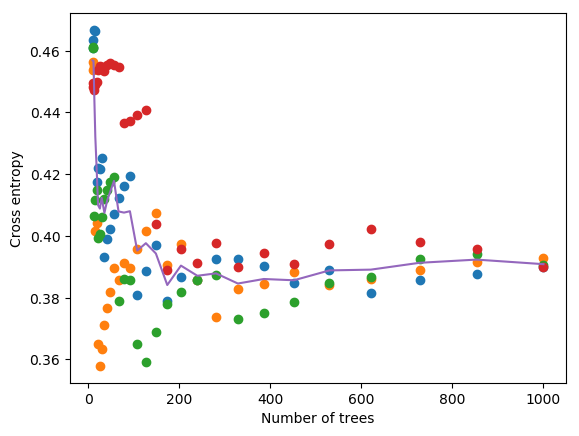

In [12]:
nruns  = 4
curves = learning_curve!(mach,
             resampling = Holdout(fraction_train=0.8),
             range      = r,
             measure    = cross_entropy,
             n          = nruns,
             verbosity  = 0)
using PyPlot

figure()

for i ∈ 1:nruns
    plot(curves.parameter_values, curves.measurements[:, i],
         linestyle="none", marker="o")
end
plot(curves.parameter_values, sum(curves.measurements, dims=2)/nruns)

xlabel("Number of trees")
ylabel("Cross entropy")

gcf()

In [13]:
savefig("fig_interm-ensemble_learning-curve.pdf")

Let's set the number of atoms to 100 for now

In [14]:
bag.n = 100

100

We can inspect the parameters of the ensemble like so:

In [15]:
params(bag)

(atom = (pruning_purity = 1.0,
         max_depth = -1,
         min_samples_leaf = 1,
         min_samples_split = 2,
         min_purity_increase = 0.0,
         n_subfeatures = 0,
         display_depth = 5,
         post_prune = false,
         merge_purity_threshold = 0.9,
         pdf_smoothing = 0.05,),
 weights = Float64[],
 bagging_fraction = 0.8,
 rng = MersenneTwister(UInt32[0x000004d2]),
 n = 100,
 parallel = true,
 out_of_bag_measure = Any[],)

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*